In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Params_PLD.jl")
include("Data_Generation_PLD.jl")
include("Estimation_PLD.jl")
include("Estimation_PLD_Fast.jl")
include("Models_PLD.jl")
include("Evaluation_PLD.jl")
include("Implement_All_Methods_PLD.jl")
include("Figures_PLD.jl")

hist_profit_distribution (generic function with 1 method)

In [2]:
Params = get_default_params_PLD()
N = Params["N"] # number of products
N_x = Params["N_x"] # dimension of product features
c_l = Params["c_l"] 
d_r = Params["d_r"]
rev_gap = Params["rev_gap"]
N_u = Params["N_u"] # dimension of customer features
S_train = Params["S_train"] # training data size
S_test = Params["S_test"] # test data size
N_Max = Params["N_Max"] # maximum assortment size
N_nonzero = Params["N_nonzero"] # number of nonzero entries in A
Time_Limit = Params["Time_Limit"] # time limit for optimization
dual_norm = Params["dual_norm"] # dual norm for robust optimization
gamma_list = Params["gamma_list"] # list of gamma values for robust optimization
psi_lb = Params["psi_lb"] # lower bound for psi
psi_ub = Params["psi_ub"] # upper bound for psi
phi_lb = Params["phi_lb"]   # lower bound for phi
phi_ub = Params["phi_ub"]  # upper bound for phi
num_c = Params["num_c"] # number of customer segments
instances = Params["instances"] # number of instances
seed = Params["seed"] # random seed
coef_this = Params["coef_this"] # coefficient for data generation
coef_Wang_Qi_Shen = Params["coef_Wang_Qi_Shen"] # coefficient for Wang, Qi, Shen data generation

(alp0_lb = 1.0, alp0_ub = 2.0, alp_lb = -1.0, alp_ub = 1.0, beta_lb = -2.0, beta_ub = 2.0, A_lb = -2.0, A_ub = 2.0, r0_lb = 0.0, r0_ub = 1.0, r_lb = -1.0, r_ub = 1.0)

In [3]:
Random.seed!(seed)
is_Wang_Qi_Shen = false;
is_same_util_para = true;
if is_Wang_Qi_Shen
    coef_para_Input = coef_Wang_Qi_Shen;
    project_dir = "Wang_Qi_Shen_N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
else
    coef_para_Input = coef_this;
    project_dir = "N=$(N)_N_x=$(N_x)_N_u=$(N_u)_N_nonzero=$(N_nonzero)_dr=$(d_r[1])_seed=$(seed)"
end
if is_same_util_para
    println("Generate data with the same utility parameters for all instances.")
    theta_true_Fixed, r_params_Fixed = Generate_Wang_Qi_Max_True_Paras(N_x,N_u,N_nonzero,coef_para_Input);
    project_dir = string(project_dir, "_Same_Util_Para/")
else
    println("Generate data with different utility parameters for all instances.")
    project_dir = string(project_dir, "_Diff_Util_Para/")
end
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/Product_Line_Design_ECP_Estimation/")

data_dir = "/Users/zhangxun/科大云盘/Research/Robust_Logit_Based_Analytics/Data/Product_Line_Design/Training_Data_Size/"
data_dir = string(data_dir,project_dir)
if !isdir(data_dir)
    mkpath(data_dir)
end
println("Data directory: ", data_dir)
save(string(data_dir, "Params.jld2"), Params);

Generate data with the same utility parameters for all instances.
Data directory: /Users/zhangxun/科大云盘/Research/Robust_Logit_Based_Analytics/Data/Product_Line_Design/Training_Data_Size/N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/


In [4]:
function compute_w(params,z_input)
    alpha0 = params.alpha0
    alpha = params.alpha
    beta = params.beta
    A = params.A
    nu0 = alpha0 + beta' * z_input;
    nu = alpha .+ A * z_input;
    return nu0,nu
end

compute_w (generic function with 1 method)

### Lambda = 0.0

In [5]:
is_ridge = false
lambda = 0.0
S_train_list = [50, 100, 200]

3-element Vector{Int64}:
  50
 100
 200

In [6]:
# function compute_r_bounds(r,index_given,N,N_x,Time_Limit,rev_gap,c_l,d_r,model_sense)
#     model = Model(Mosek.Optimizer)
#     set_attribute(model, "QUIET", true)
#     set_optimizer_attribute(model, "MSK_DPAR_OPTIMIZER_MAX_TIME", Time_Limit) 
#     # 定义变量
        
#     @variable(model, X[1:N, 1:N_x], Bin)        # 二进制变量 x_{jk}
#     @constraint(model, X * c_l .>= d_r)

#     for ind1 in 1:(N-1)
#         @constraint(model, r' * X[ind1,:] >= r' * X[(ind1+1),:] + rev_gap)
#     end
#     if model_sense == "Max"
#         @objective(model, Max, r' * X[index_given,:])
#     elseif model_sense == "Min"
#         @objective(model, Min, r' * X[index_given,:])
#     end

#     optimize!(model)
#     status = JuMP.termination_status(model)
#     # println("status: ", status)
#     # solution_summary(model)
#     if status == MOI.OPTIMAL  || status == MOI.TIME_LIMIT
#         sol_status = string(status)
#         obj_val = objective_value(model)
#         X_val = round.(value.(X))
#         solve_time = JuMP.solve_time(model)
#     else
#         sol_status = "Others"
#         obj_val = NaN
#         X_val = ones(N,N) .* NaN
#         solve_time = NaN
#     end
#     return sol_status, obj_val, X_val, solve_time
# end

In [7]:
# r = r_params.r
# phi_lb = zeros(N)
# for n in 1:N 
#     sol_status, obj_min, X_val, solve_time = compute_r_bounds(r,n,N,N_x,Time_Limit,rev_gap,c_l,d_r,"Min")
#     sol_status, obj_max, X_val, solve_time = compute_r_bounds(r,n,N,N_x,Time_Limit,rev_gap,c_l,d_r,"Max")
#     phi_lb[n] = obj_min - obj_max
# end

In [8]:
for S_train in S_train_list
    println("********** S_train = ",S_train," **********")

    Input_Data = Dict()
    RST_True_All = Dict()
    RST_ETO_All = Dict()
    RST_RO_All = Dict()
    ins = 1
    while ins <= instances
        if is_same_util_para
            Input_Data_this = Generate_Data_this_Same_Para(N_Max,N_x,N_u,S_train,S_test,theta_true_Fixed, r_params_Fixed);
        else
            Input_Data_this = Generate_Data_this(N_x,N_u,N_nonzero,S_train,S_test,m,coef_para_Input)
        end
        theta_true,r_params,X_train,Y_train,Z_train,Asorrtment_train,X_test,Y_test,Z_test = Get_Input_Data(Input_Data_this);
        Input_Data["ins=$(ins)"] = Input_Data_this
        nu0_true,nu_true = compute_w(theta_true,Z_test[1,:])  
        nu_all_true = [nu0_true;nu_true]

        theta_Input = theta_true
        RST_True,status_True = solve_ETO_This(S_test,N,N_x,theta_Input,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
        # println("Oracle: status = ",status_True,",obj=",RST_True["obj"][1])
        if status_True != "OPTIMAL"
            println("Warning: The true model did not reach optimality")
            continue
        end
        RST_True_All["ins=$(ins)"] = RST_True

        theta_hat = Estimation_This(N_Max,N_x,N_u,Y_train,X_train,Z_train, Asorrtment_train,is_ridge, lambda)
        nu0_hat,nu_hat = compute_w(theta_hat,Z_test[1,:])  
        nu_all_hat = [nu0_hat;nu_hat]
        if any(isnan, nu_all_hat)
            println("Estimate contains NaN values.")
            continue
        end

        if norm(vec(nu_all_true .- nu_all_hat),2) >= 20
            println("Estimate is too far from true parameters.")
            continue
        end

        RST_ETO,status_ETO = solve_ETO_This(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test)
        # println("ETO: status = ",status_ETO,",obj=",RST_ETO["obj"][1])
        if status_ETO != "OPTIMAL"
            println("Warning: The ETO model did not reach optimality")
            continue
        end
        RST_ETO_All["ins=$(ins)"] = RST_ETO
        
        RST_RO_this = Dict()
        gamma = gamma_list[1]
        RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
        # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
        if status_RO != "OPTIMAL"
            println("Warning: The RO model did not reach optimality")
            continue
        end
        # ratio = abs(RST_RO["obj"][1] - RST_ETO["obj"][1])/abs(RST_ETO["obj"][1])
        ratio = abs(RST_RO["profit"][1] - RST_ETO["profit"][1])/abs(RST_ETO["profit"][1])
        if ratio > 1e-4
            println("Warning: The RO obj is not equivalent to ETO obj")
            continue
        end
        RST_RO_this[string("gamma=",gamma)] = RST_RO

        for g_index in 2:length(gamma_list)
            gamma = gamma_list[g_index]
            RST_RO,status_RO = solve_RO_this(S_test,N,N_x,theta_hat,theta_true,r_params,c_l,d_r,rev_gap,num_c,Time_Limit,Z_test,gamma,psi_lb,psi_ub,phi_lb,phi_ub)
            # println("gamma = $gamma, RO: status = ",status_RO,",obj=",RST_RO["obj"][1])
            RST_RO_this[string("gamma=",gamma)] = RST_RO
        end
        RST_RO_All["ins=$(ins)"] = RST_RO_this
        println("******* ins = ",ins,"*********")
        ins = ins + 1
    end
    save(string(data_dir, "Input_Data_S=$(S_train)_lambda=$(lambda).jld2"), Input_Data);
    save(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"), RST_True_All);
    save(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"), RST_ETO_All);
    save(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"), RST_RO_All);
end

********** S_train = 50 **********
******* ins = 1*********
******* ins = 2*********
******* ins = 3*********
******* ins = 4*********
******* ins = 5*********
******* ins = 6*********
******* ins = 7*********
******* ins = 8*********
******* ins = 9*********
******* ins = 10*********
******* ins = 11*********
******* ins = 12*********
******* ins = 13*********
******* ins = 14*********
******* ins = 15*********
******* ins = 16*********
******* ins = 17*********
******* ins = 18*********
******* ins = 19*********
******* ins = 20*********
******* ins = 21*********
******* ins = 22*********
******* ins = 23*********
******* ins = 24*********
******* ins = 25*********
******* ins = 26*********
******* ins = 27*********
******* ins = 28*********
******* ins = 29*********
******* ins = 30*********
******* ins = 31*********
******* ins = 32*********
******* ins = 33*********
******* ins = 34*********
******* ins = 35*********
******* ins = 36*********
******* ins = 37*********
******* ins 

## S = 50

In [27]:
S_train = 50
RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

In [28]:
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
gamma_list = gamma_list
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0]


In [29]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:0.5978
profit ETO:0.4511
profit RO:[0.4511 0.4605 0.4678 0.4782 0.4885 0.4931 0.496 0.504 0.5083 0.5095 0.5037]


In [12]:
# function obtain_obj(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list)
#     profit_True = zeros(instances);
#     profit_ETO = zeros(instances);
#     profit_RO = zeros(instances, length(gamma_list));
#     for ins in 1:instances
#         profit_True[ins] = mean(RST_True_All["ins=$(ins)"]["obj"])
#         profit_ETO[ins] = mean(RST_ETO_All["ins=$(ins)"]["obj"])
#         for g_index in 1:length(gamma_list)
#             gamma = gamma_list[g_index]
#             # println("gamma = $gamma")
#             RST_RO_Gamma = RST_RO_All["ins=$(ins)"]["gamma=$gamma"]
#             profit_RO[ins,g_index] = mean(RST_RO_Gamma["obj"])
#         end
#     end
#     return profit_True, profit_ETO, profit_RO
# end

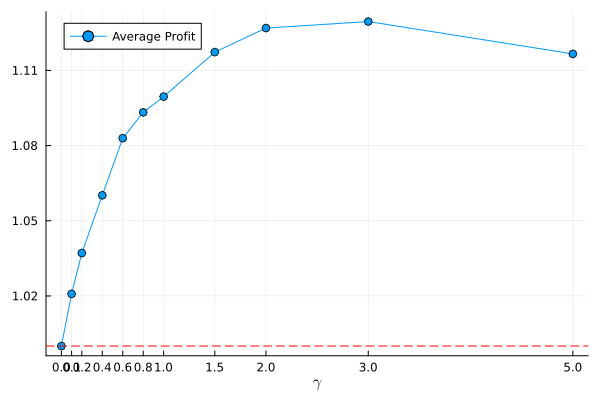

"/Users/zhangxun/科大云盘/Research/Robust_Logit_Based_Analytics/Data/Product_Line_Design/Training_Data_Size/N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/RPLD_vs_ETOPLD_lambda=0.0.pdf"

In [30]:
fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
include_std = false
line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

## S = 100

In [31]:
S_train = 100
RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

In [32]:
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
gamma_list = gamma_list
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0]


In [33]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:0.5979
profit ETO:0.5064
profit RO:[0.5064 0.5095 0.516 0.524 0.5307 0.5332 0.5326 0.5308 0.5264 0.5156 0.5081]


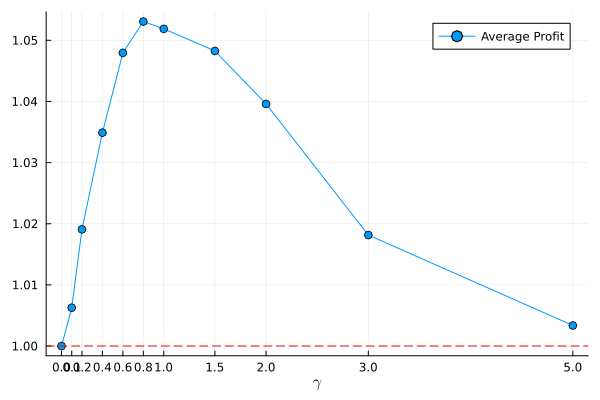

"/Users/zhangxun/科大云盘/Research/Robust_Logit_Based_Analytics/Data/Product_Line_Design/Training_Data_Size/N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/RPLD_vs_ETOPLD_lambda=0.0.pdf"

In [34]:
fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
include_std = false
line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

## S = 200

In [35]:
S_train = 200
RST_True_All = load(string(data_dir, "RST_True_S=$(S_train)_lambda=$(lambda).jld2"));
RST_ETO_All = load(string(data_dir, "RST_ETO_S=$(S_train)_lambda=$(lambda).jld2"));
RST_RO_All = load(string(data_dir, "RST_RO_S=$(S_train)_lambda=$(lambda).jld2"));

In [37]:
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_All["ins=1"])])
gamma_list = gamma_list
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0]


In [38]:
profit_True, profit_ETO, profit_RO = obtain_profits(RST_True_All, RST_ETO_All, RST_RO_All, instances, gamma_list);
println("profit True:",round.(mean(profit_True),digits=4))
println("profit ETO:",round.(mean(profit_ETO),digits=4))
println("profit RO:",round.(mean(profit_RO,dims=1),digits=4))

profit True:0.5979
profit ETO:0.5492
profit RO:[0.5492 0.5545 0.5566 0.5585 0.5584 0.5567 0.5558 0.5493 0.5426 0.5256 0.5152]


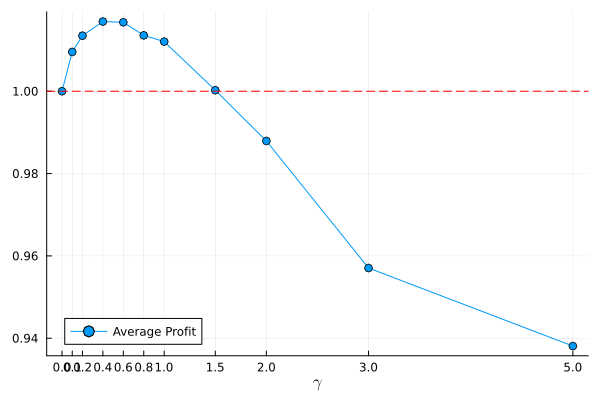

"/Users/zhangxun/科大云盘/Research/Robust_Logit_Based_Analytics/Data/Product_Line_Design/Training_Data_Size/N=3_N_x=8_N_u=1_N_nonzero=5_dr=2.0_seed=2_Same_Util_Para/RPLD_vs_ETOPLD_lambda=0.0.pdf"

In [39]:
fig_name = string(data_dir, "RPLD_vs_ETOPLD_lambda=$lambda.pdf")
include_std = false
line_plot_RPLD_vs_ETOPLD(profit_ETO,profit_RO,gamma_list,include_std,fig_name)

In [22]:
# profit_True = zeros(instances);
# profit_ETO = zeros(instances);
# profit_RO = zeros(instances, length(gamma_list));
# for ins in 1:instances
#     profit_True[ins] = mean(RST_True_All["ins=$(ins)"]["profit"])
#     profit_ETO[ins] = mean(RST_ETO_All["ins=$(ins)"]["profit"])
# end
# println("True profit: mean = ", mean(profit_True), ", std = ", std(profit_True))
# println("ETO profit: mean = ", mean(profit_ETO), ", std = ", std(profit_ETO))
# println("ETO/True Ratio = ", mean(profit_ETO)/mean(profit_True))

In [23]:
# Profit_ETO_All_Ins = profit_ETO./mean(profit_ETO)
# Profit_RO_All_Ins = Dict();
# for g_index in 1:length(gamma_list)
#     gamma=gamma_list[g_index]
#     Profit_RO_All_Ins["gamma=$(gamma)"] = profit_RO[:,g_index]./mean(profit_ETO)
# end

# chosen_indices = [1,5,7,9]
# gamma_chosen = gamma_list[chosen_indices]
# data = [Profit_ETO_All_Ins, [Profit_RO_All_Ins["gamma=$(gamma)"] for gamma in gamma_chosen]...]
# labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# fig_name = string(data_dir, "Boxplot_RPLD_vs_ETOPLD_lambda=$(lambda)_Normalize.pdf")
# boxplot_RPLD_vs_ETOPLD(data,labels,fig_name)